In [82]:
# Importing libraries

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
# Reading .csv Files using Pandas

In [85]:
# Reading employee_data.csv as df_employee
df_employee = pd.read_csv("employee_data.csv")
# Reading insurance_data.csv as df_insurance
df_insurance = pd.read_csv("insurance_data.csv")
# Reading vendor_data.csv as df_vendor
df_vendor = pd.read_csv("vendor_data.csv")

In [86]:
# Task # 1
# Merge the 3 dataset and create 1 view of data.
# You can merge insurance_data.csv and employee_data.csv on AGENT_ID 
# You can merge insurance_data.csv and vendor_data.csv on VENDOR_ID 
# Note: Use left Outer join as not all claims require Vendor

# using pd.merge() to merge the two dataframes.
df_insurance_employee = pd.merge(df_employee,df_insurance,how = "left" , on = ["AGENT_ID"])
df_final = pd.merge(df_vendor,df_insurance_employee , how = "left", on = ["VENDOR_ID"])
#Dropping the na data with respect to POLICY_NUMBER as its most imp. column
df_final.dropna(subset = ["POLICY_NUMBER"], inplace=True)
df_final = df_final.reset_index(drop=True)
# df_final is the single view of all the dataset

The Top 3 Insurance Types Are INSURANCE_TYPE
Life        62599000.0
Property    27529000.0
Health      12232000.0
Name: CLAIM_AMOUNT, dtype: float64


<AxesSubplot:xlabel='INSURANCE_TYPE'>

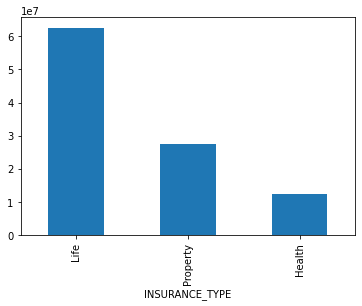

In [87]:
# Task #2
# Business Leader wants to find Top 3 Insurance Type 
#where we are getting most insurance claims?

# using groupby function to group insurance type with sum of claim amount
insurance_type = df_final.groupby("INSURANCE_TYPE")["CLAIM_AMOUNT"].sum()
# sorting insuance_type with sort function
insurance_type_sort = insurance_type.sort_values(ascending=False)
#Finding top 3 values using nlargest function
insurance_type_sort_top3 = insurance_type_sort.nlargest(3)
#printing top3 values
print(f"The Top 3 Insurance Types Are {insurance_type_sort_top3}")
#plotting bar chart of top 3 Categories
insurance_type_sort_top3.plot.bar()


Index(['CA', 'CO', 'AR', 'CT', 'AL'], dtype='object', name='STATE')


<AxesSubplot:xlabel='STATE'>

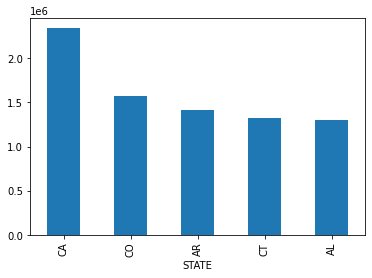

In [88]:
# Task #3
# Business Leader wants to find Top 5 States 
# where we are getting most insurance claims for customer belonging to HIGH(H) risk segment?

# Creating pivot table by indexing with states and aggregates values by taking the sum
df_pivot_state = pd.pivot_table(df_final[df_final.RISK_SEGMENTATION=="H"],index=["STATE"],aggfunc = np.sum)
# sorting pivot table by claim amount
df_pivot_state_sort = df_pivot_state.reindex(df_pivot_state["CLAIM_AMOUNT"].sort_values(ascending = False).index)
#selecting top 5 states
print(df_pivot_state_sort.head(5).index)
#plotting bar plot for top 5 states
Top5States = df_pivot_state_sort["CLAIM_AMOUNT"].nlargest(5)
Top5States.plot.bar()



In [89]:
# Task #4
# Business wants to create a new variable “COLOCATION” 
# which will have following values 
# IF Customer State == Incident State == Agent Address State THEN 1 ELSE 0
# Find the mean of this new column

# Creating empty series for conditional result
COLOCATION = pd.Series([])
#creating for loop with the length data
for i in range(len(df_final)):
    # using if And conditions to get conditional results
    if df_final["STATE_x"][i] == df_final["STATE_y"][i] and df_final["STATE_x"][i] == df_final["INCIDENT_STATE"][i] and df_final["STATE_y"][i] == df_final["INCIDENT_STATE"][i]:
        #if condition satisfies COLOCATION = 1
        COLOCATION[i]= 1
    # if not Satisfy then COLOCATION = 0
    else: COLOCATION[i]= 0    

# Converting Series[COLOCATION] to Column of df_final      
df_final['COLOCATION'] = pd.DataFrame(COLOCATION) 
#finding mean of the new column
Mean = df_final['COLOCATION'].mean()
Mean = format(Mean,".5f")
print(f"The Mean Of The New Column is {Mean}")



C:\Users\OMKAR\AppData\Local\Temp\ipykernel_9620\3606727864.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  COLOCATION = pd.Series([])


The Mean Of The New Column is 0.00429


In [90]:
#Task #5
# Data entry error was detected in the data and you are required to correct it. 
# If for any claim transaction “AUTHORITY_CONTACTED” is NOT “Police” and POLICE_AVAILABLE == 1
# Then Update “AUTHORITY_CONTACTED” to Police.

# using np.where to convert AUTHORITY_CONTACTED to police if condition satisfied
df_final["AUTHORITY_CONTACTED"]= np.where(df_final["AUTHORITY_CONTACTED"] != "Police") and np.where(df_final["POLICE_REPORT_AVAILABLE"]==1,"Police",df_final["AUTHORITY_CONTACTED"])
# reseting index
df_final = df_final.reset_index(drop=True)

In [91]:
# Task #6
# Business wants to check the Claim Amount for deviation for each transaction, they would
# like you to calculate as follow
# CLAIM_DEVIATION = AVG_CLAIM_AMOUNT_FOR_LAST_30DAYS (same insurance type)
# / CURRENT_CLAIM_AMOUNT
# If the value < 0.5 THEN CLAIM_DEVIATION = 1 ELSE 0
# If there is less than 30 days of transaction history THEN
# -1 Note: LAST_30DAYS does not include current da


# for above calculating the sorted table base on TXN_DATE_TIME and considering the INSURANCE_TYPE as DEVIATION

# Converting the type of TXN_DATE_TIME column to datetime
df_final["TXN_DATE_TIME"] = pd.to_datetime(df_final["TXN_DATE_TIME"])
# sort the dataframe
df_final = df_final.sort_values(by = ["TXN_DATE_TIME"], ascending = [False], na_position = "first")
#reset index
df_final = df_final.reset_index(drop=True)

#created empty data series for pandas operation
CLAIM_DEVIATION = pd.Series([])

#using for loop to get values for CLAIM_DEVIATION
# i range define as from 0 to length of dataframe-30
for i in range(0,len(df_final)-30):
    #creating variable
    AVG_CLAIM_AMOUNT_FOR_LAST_30DAYS = 0
    #applying filters
    df_temp = df_final[df_final['INSURANCE_TYPE'][i]== df_final['INSURANCE_TYPE']]
    #df_temp = df_temp.reset_index(drop=True)
    df_temp = df_temp[df_final['TXN_DATE_TIME'][i] != df_temp['TXN_DATE_TIME']]
    
    if i>=1 :
        df_temp = df_temp[df_temp['TXN_DATE_TIME']<df_final['TXN_DATE_TIME'][i-1]]
    
    df_temp = pd.pivot_table(df_temp, index=['TXN_DATE_TIME'],aggfunc=np.sum)
    # finding current claim amount
    CURRENT_CLAIM_AMOUNT = df_final['CLAIM_AMOUNT'][i]
    # reset index
    df_temp = df_temp.reset_index(drop=True)
    # for loop with range of df_temp length
    for t in range(len(df_temp)):
        #print(t)
        AVG_CLAIM_AMOUNT_FOR_LAST_30DAYS = df_temp['CLAIM_AMOUNT'][t]+AVG_CLAIM_AMOUNT_FOR_LAST_30DAYS
        #applying conditions
        if t==29:
            CLAIM_DEVIATION_val = ((AVG_CLAIM_AMOUNT_FOR_LAST_30DAYS)/30)/CURRENT_CLAIM_AMOUNT
            
            if CLAIM_DEVIATION_val < 0.5:
                CLAIM_DEVIATION[i] = 1
            else:
                CLAIM_DEVIATION[i] = 0
                            
            break
# for loop for last less than 30 days
for i in range(len(df_final)-30,len(df_final)):
    CLAIM_DEVIATION[i] = -1
 
    
    #print(df_temp['CLAIM_AMOUNT'][i])
#converting series into column                
df_final['CLAIM_DEVIATION'] = pd.DataFrame(CLAIM_DEVIATION)   
df_final = df_final.reset_index(drop=True)


C:\Users\OMKAR\AppData\Local\Temp\ipykernel_9620\169433895.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  CLAIM_DEVIATION = pd.Series([])


In [92]:
# Task #7
# Find All Agents who have worked on more than 2 types of Insurance Claims. 
#Sort them by Total Claim Amount Approved under them in descending order

# Creating a column for operation
df_final["Type"] = 1
# getting only value when claim status is accepted
df_claim_status = df_final[df_final.CLAIM_STATUS == "A"]
#creating pivot table to get total claim amount and sum of insurance type wrt agent id
df_pivot_Agents = pd.pivot_table(df_claim_status, index=["AGENT_NAME"],values = ["Type","CLAIM_AMOUNT"],aggfunc=np.sum)
# applying condition that Agent type>2
df_pivot_Agents = df_pivot_Agents[df_pivot_Agents["Type"]>2]
# sorting values wrt total claim amount
df_pivot_Agents.sort_values('CLAIM_AMOUNT',axis = 0, ascending = False, inplace = True, na_position = "first")
# printing top 10 pivot agents who worked for more than 2 Insurance type
print("Agents who worked for more than 2 Insurance types are")
agent_name = pd.DataFrame(df_pivot_Agents.head(10).index)
agent_name

Agents who worked for more than 2 Insurance types are


,AGENT_NAME
0,Don Filkins
1,Frank Kuss
2,Jean Cedeno
3,Salvador Soriano
4,Robert Ward
5,Clara Barnett
6,Don Ritchie
7,Freda Dudley
8,Jose Dame
9,Cleveland Feyh


In [93]:
# Task #8
# Mobile & Travel Insurance premium are discounted by 10%
# Health and Property Insurance premium are increased by 7%
# Life and Motor Insurance premium are marginally increased by 2%
# What will be overall change in % of the Premium Amount Collected for all these Customer?

# using np.where function to create new column DISCOUNTED_PREMIUM
df_final["DISCOUNTED_PREMIUM"] = np.where(df_final["INSURANCE_TYPE"] == "Mobile",(df_final["PREMIUM_AMOUNT"]-df_final["PREMIUM_AMOUNT"]*0.10),0)
df_final["DISCOUNTED_PREMIUM"] = np.where(df_final["INSURANCE_TYPE"] == "Travel",(df_final["PREMIUM_AMOUNT"]-df_final["PREMIUM_AMOUNT"]*0.10),df_final["DISCOUNTED_PREMIUM"])
df_final["DISCOUNTED_PREMIUM"] = np.where(df_final["INSURANCE_TYPE"] == "Health",(df_final["PREMIUM_AMOUNT"]*1.07),df_final["DISCOUNTED_PREMIUM"])
df_final["DISCOUNTED_PREMIUM"] = np.where(df_final["INSURANCE_TYPE"] == "Property",(df_final["PREMIUM_AMOUNT"]*1.07),df_final["DISCOUNTED_PREMIUM"])
df_final["DISCOUNTED_PREMIUM"] = np.where(df_final["INSURANCE_TYPE"] == "Life",(df_final["PREMIUM_AMOUNT"]*1.02),df_final["DISCOUNTED_PREMIUM"])
df_final["DISCOUNTED_PREMIUM"] = np.where(df_final["INSURANCE_TYPE"] == "Motor",(df_final["PREMIUM_AMOUNT"]*1.02),df_final["DISCOUNTED_PREMIUM"])

# Increase = diff between two values(new-old)
Increase = df_final["DISCOUNTED_PREMIUM"].sum()-df_final["PREMIUM_AMOUNT"].sum()
# IncreasePercentage = Increase/Originalno.*100
IncreasePerventage = (Increase/df_final["DISCOUNTED_PREMIUM"].sum())*100
# Printing Change in Percentage
IncreasePerventage = format(IncreasePerventage,".2f")
print(f" The Change in Percentage Is {IncreasePerventage}%")



 The Change in Percentage Is 2.56%


In [94]:
# Task #9
# Business wants to give discount to customer who are loyal and under stress due to Covid
# 19. They have laid down an eligibility Criteria as follow
# IF CUSTOMER_TENURE > 60 AND EMPLOYMENT_STATUS = “N”
# AND NO_OF_FAMILY_MEMBERS >=4 THEN 1 ELSE 0
# Create a new column “ELIGIBLE_FOR_DISCOUNT” and find it mean

# using np.where applying all the conditions for ELIGIBLE_FOR_DISCOUNT Column
df_final['ELIGIBLE_FOR_DISCOUNT'] =  np.where(df_final["TENURE"] >60 ) and np.where( df_final["EMPLOYMENT_STATUS"] == 'N') and np.where( df_final["NO_OF_FAMILY_MEMBERS"] >= 4,1,0)
# reseting index
df_final = df_final.reset_index(drop=True)
# finding mean of the column
ELIGIBLE_FOR_DISCOUNT = df_final['ELIGIBLE_FOR_DISCOUNT'].mean()
# printing mean in well format
ELIGIBLE_FOR_DISCOUNT = format(ELIGIBLE_FOR_DISCOUNT,'.2f')

print(f"The Mean Of The ELIGIBLE_FOR_DISCOUNT Column Is {ELIGIBLE_FOR_DISCOUNT}")
     

The Mean Of The ELIGIBLE_FOR_DISCOUNT Column Is 0.66


In [95]:
# Task #10
# Business wants to check Claim Velocity which is defined as follow
# CLAIM_VELOCITY = NO_OF_CLAIMS_IN_LAST30DAYS (for the current insurance type)
# / NO_OF_CLAIMS_IN_LAST3DAYS (for the current insurance type)
# Note: LAST30DAYS & LAST3DAYS does not include current
# day


# Converting the type of TXN_DATE_TIME column to datetime
df_final['TXN_DATE_TIME'] = pd.to_datetime(df_final['TXN_DATE_TIME'])
# sort the dataframe
df_final = df_final.sort_values(by = ['TXN_DATE_TIME'], ascending = [False], na_position = 'first')
# reset index
df_final = df_final.reset_index(drop=True)

#created empty data series for pandas operation
CLAIM_VELOCITY = pd.Series([])

# using for loop with i range of 0 to length of df_final-30
for i in range(0,len(df_final)-30):
    #creating empty list
    df_temp = []
    #creating variables
    CLAIM_VELOCITY_NUM = 0
    CLAIM_VELOCITY_val = 0
    #applying filters
    df_temp = df_final[df_final['INSURANCE_TYPE'][i]== df_final['INSURANCE_TYPE']]
    df_temp = df_temp[df_final['TXN_DATE_TIME'][i] != df_temp['TXN_DATE_TIME']]
    
    if i>=1 :
        df_temp = df_temp[df_temp['TXN_DATE_TIME']<df_final['TXN_DATE_TIME'][i-1]]
    #creating pivot table    
    df_temp = pd.pivot_table(df_temp, index=['TXN_DATE_TIME'],aggfunc=np.sum)
    #reset index
    df_temp = df_temp.reset_index(drop=True)
    
    # for loop with the length of df_temp
    for t in range(len(df_temp)):
        #print(t)
        CLAIM_VELOCITY_NUM += 1
        #applying conditions
        if t==2:
            CLAIM_VELOCITY_NUM_3 = CLAIM_VELOCITY_NUM
            
        if t==29:
            CLAIM_VELOCITY_NUM_30 = CLAIM_VELOCITY_NUM
            CLAIM_VELOCITY_val = (CLAIM_VELOCITY_NUM_30)/(CLAIM_VELOCITY_NUM_3)
            CLAIM_VELOCITY[i] = CLAIM_VELOCITY_val
            break
# for loop for last less than 30 days        
for i in range(len(df_final)-30,len(df_final)):
    CLAIM_VELOCITY[i] = 0 
    #print(df_temp['CLAIM_AMOUNT'][i])
#converting series into column                
df_final['CLAIM_VELOCITY'] = pd.DataFrame(CLAIM_VELOCITY)   
df_final = df_final.reset_index(drop=True)

C:\Users\OMKAR\AppData\Local\Temp\ipykernel_9620\2506511812.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  CLAIM_VELOCITY = pd.Series([])


In [96]:
# Task #11
# Find all low performing agents i.e. 
# employees who are in the bottom 5 percentile based on Claims worked by them.

# Creating 1 Coumn as ClaimCount
df_final["CLAIM_COUNT"]=1
# Using Groupby Func 
df_low_agents = df_final.groupby("AGENT_ID")["CLAIM_COUNT"].sum()
# Finding 5th percentile Value
percentile_5 = df_low_agents.quantile(q=[0.5])
#Creating DataFrame
df_low_agents = pd.DataFrame(df_low_agents)
#Filter only Values which claim_count is less than equal to 5
df_low_agents=df_low_agents[df_low_agents["CLAIM_COUNT"]<=5]
#Sorting Values
df_low_agents =df_low_agents.sort_values(by = "CLAIM_COUNT")
# Printing Agent Names
print(f" The Low Performing Agets Are")

Agents = pd.DataFrame(df_low_agents.head(10).index)
Agents


 The Low Performing Agets Are


,AGENT_ID
0,AGENT01024
1,AGENT00120
2,AGENT00780
3,AGENT01154
4,AGENT00656
5,AGENT00645
6,AGENT00621
7,AGENT00958
8,AGENT00863
9,AGENT00253


In [97]:
# Task #12
# Business wants to find all Suspicious Employees (Agents).
# IF TOTAL CLAIM AMOUNT which meet below criteria is >= 15000 THEN AGENT is classified
# as Suspicious ELSE Not
# CLAIM_STATUS = Approved AND CUSTOMER_RISK_SEGMENTATION = High
# AND INCIDENT_SEVERITY = “Major Loss”
# If Suspicious, then 1 ELSE 0. Find mean of this column


# Creating pivot table
df_pivot_agentclaim = pd.pivot_table(df_final,index = "AGENT_NAME",values = ["CLAIM_AMOUNT"],aggfunc=np.sum)

#Creating empty series for pandas operation
Suspicious = pd.Series([])
# using for loop appending value in empty series
for i in range(len(df_pivot_agentclaim)):
    if df_pivot_agentclaim["CLAIM_AMOUNT"][i]>= 15000:
        Suspicious[i] = 1
    else:
        Suspicious[i] = 0
#converting series as a df_final column        
df_final["Suspicious"] = pd.DataFrame(Suspicious)  

#creating empty list    
Suspicious_Employees = []
#using for loop appending count in list
for i in range(len(df_final)):
    Suspicious_Employees_value = 0
    if df_final["CLAIM_STATUS"][i]== "A" and df_final["RISK_SEGMENTATION"][i] == "H" and df_final["INCIDENT_SEVERITY"][i]=="Major Loss" :
        Suspicious_Employees_value += 1
    else:
        Suspicious_Employees_value = 0
    # appending value in empty list    
    Suspicious_Employees.append(Suspicious_Employees_value)    
        
#Finding mean of the columns
Mean = sum(Suspicious_Employees)/len(Suspicious_Employees)
Mean = format(Mean,".2f")
print(f"The Mean Of The Column Is {Mean}")

C:\Users\OMKAR\AppData\Local\Temp\ipykernel_9620\786456629.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Suspicious = pd.Series([])


The Mean Of The Column Is 0.04
